# Feature Extraction and Model Training with Gender

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as ipd  # To play sound in the notebook
import os
from tqdm import tqdm
import datetime
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from pydub import AudioSegment, effects
import seaborn as sns
from sklearn.utils import shuffle
import noisereduce as nr
import pyaudio
import time

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
RAVDESS = "Data/RAVDESS/audio_speech_actors_01-24/"
TESS = "Data/TESS/"

EMOTIONS = {
    0: 'angry',
    1: 'calm',
    2: 'disgust',
    3: 'fear',
    4: 'happy',
    5: 'sad',
    6: 'surprise'
}

In [3]:
RAVDESS_folder_names = os.listdir(RAVDESS)
RAVDESS_folder_names.sort()

file_emotions = []
file_gender = []
file_intensity = []
file_paths = []
RAV_EMOTIONS = {
    1: 'calm',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}
for i in RAVDESS_folder_names:
    if os.path.isdir(RAVDESS + i):
        file_names = os.listdir(RAVDESS + i)

        for file in file_names:
            parts = file.split('.')[0].split('-')
            file_emotions.append(RAV_EMOTIONS[int(parts[2])])
            # file_intensity.append(int(parts[3]))
            if int(parts[6]) % 2 == 0:
                file_gender.append('female')
            else:
                file_gender.append('male')
            file_paths.append(RAVDESS + i + '/' + file)

for file in os.listdir(TESS):
    parts = file.split('.')[0].split('_')
    if parts[2] == 'ps':
        parts[2] = 'surprise'
    elif parts[2] == 'neutral':
        parts[2] = 'calm'
    file_emotions.append(parts[2])
    if parts[0] == 'OAF':
        file_gender.append('male')
    else:
        file_gender.append('female')

    file_paths.append(TESS + file)

# print(file_emotions, file_gender, file_intensity, file_paths, sep="\n")

In [5]:
labels = [
    gender + "_" + emotion
    for gender, emotion in zip(file_gender, file_emotions)
]

In [6]:
dataset = pd.DataFrame({
    'path': file_paths,
    'gender': file_gender,
    'emotion': file_emotions,
    'label': labels
})
# dataset['emotion'] = dataset['emotion'].map(EMOTIONS)
print('Shape=>', dataset.shape)
# dataset["emotion"] = dataset["emotion"]
dataset.head(50)

Shape=> (4240, 4)


path gender   emotion  \
0   Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male  surprise   
1   Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male  surprise   
2   Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     angry   
3   Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      fear   
4   Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      fear   
5   Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     angry   
6   Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male   disgust   
7   Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male       sad   
8   Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male       sad   
9   Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male   disgust   
10  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     happy   
11  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     happy   
12  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      calm   
13  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      calm   
14  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      calm   
15  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     happy   
16  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     happy   
17  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      calm   
18  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      calm   
19  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      calm   
20  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male  surprise   
21  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male  surprise   
22  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      fear   
23  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     angry   
24  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     angry   
25  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      fear   
26  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male       sad   
27  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male   disgust   
28  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male   disgust   
29  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male       sad   
30  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      calm   
31  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      calm   
32  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      calm   
33  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     happy   
34  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     happy   
35  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male  surprise   
36  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male  surprise   
37  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male   disgust   
38  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male       sad   
39  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male       sad   
40  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male   disgust   
41  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     angry   
42  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      fear   
43  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male      fear   
44  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male     angry   
45  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male  surprise   
46  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male  surprise   
47  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male       sad   
48  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male   disgust   
49  Data/RAVDESS/audio_speech_actors_01-24/Actor_0...   male   disgust   

            label  
0   male_surprise  
1   male_surprise  
2      male_angry  
3       male_fear  
4       male_fear  
5      male_angry  
6    male_disgust  
7        male_sad  
8        male_sad  
9    male_disgust  
10     male_happy  
11     male_happy  
12      male_c

In [7]:
dataset = shuffle(dataset)
# dataset = shuffle(dataset)

In [8]:
dataset.tail(10)

path  gender   emotion  \
2611                        Data/TESS/YAF_jug_happy.wav  female     happy   
3471                          Data/TESS/YAF_said_ps.wav  female  surprise   
1916                     Data/TESS/OAF_soap_disgust.wav    male   disgust   
1756                       Data/TESS/YAF_pool_happy.wav  female     happy   
3550                       Data/TESS/YAF_life_happy.wav  female     happy   
3807                          Data/TESS/YAF_hash_ps.wav  female  surprise   
1188  Data/RAVDESS/audio_speech_actors_01-24/Actor_2...  female      fear   
159   Data/RAVDESS/audio_speech_actors_01-24/Actor_0...    male       sad   
4202                    Data/TESS/YAF_goose_disgust.wav  female   disgust   
4049                       Data/TESS/YAF_sail_happy.wav  female     happy   

                label  
2611     female_happy  
3471  female_surprise  
1916     male_disgust  
1756     female_happy  
3550     female_happy  
3807  female_surprise  
1188      female_fear  
159          male_sad  
4202   female_disgust  
4049     female_happy

# Exploratry Data Analysis (EDA)

In [9]:
dataset['gender'].value_counts()

male      2120
female    2120
Name: gender, dtype: int64

In [10]:
dataset['emotion'].value_counts()

calm        688
disgust     592
fear        592
surprise    592
happy       592
angry       592
sad         592
Name: emotion, dtype: int64

In [11]:
dataset['emotion'].value_counts(normalize=True) * 100

calm        16.226415
disgust     13.962264
fear        13.962264
surprise    13.962264
happy       13.962264
angry       13.962264
sad         13.962264
Name: emotion, dtype: float64

<AxesSubplot:>

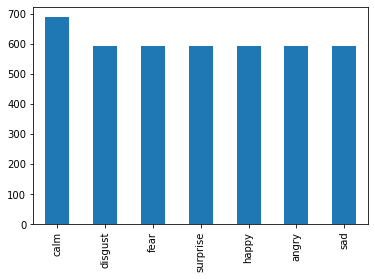

In [12]:
dataset.emotion.value_counts().plot.bar()

In [13]:
dataset['label'].value_counts()

female_calm        344
male_calm          344
male_disgust       296
female_disgust     296
female_fear        296
female_surprise    296
male_surprise      296
female_happy       296
female_angry       296
male_fear          296
male_angry         296
male_happy         296
female_sad         296
male_sad           296
Name: label, dtype: int64

<AxesSubplot:>

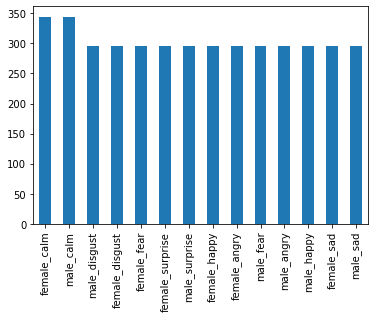

In [14]:
dataset.label.value_counts().plot.bar()

In [15]:
male_sample = []
female_sample = []
emotions_sample = []
for i in EMOTIONS.values():
    male_sample.append(dataset[dataset['emotion'] == i][
        dataset['gender'] == 'male']['path'].reset_index(drop=True)[0])
    female_sample.append(dataset[dataset['emotion'] == i][
        dataset['gender'] == 'female']['path'].reset_index(drop=True)[0])
    emotions_sample.append(
        dataset[dataset['emotion'] == i]['path'].reset_index(drop=True)[0])
print(male_sample)
print(female_sample)
emotions_sample

['Data/TESS/OAF_young_angry.wav', 'Data/RAVDESS/audio_speech_actors_01-24/Actor_23/03-01-01-01-02-01-23.wav', 'Data/RAVDESS/audio_speech_actors_01-24/Actor_15/03-01-07-01-02-02-15.wav', 'Data/TESS/OAF_hire_fear.wav', 'Data/TESS/OAF_calm_happy.wav', 'Data/TESS/OAF_mop_sad.wav', 'Data/TESS/OAF_sail_ps.wav']
['Data/TESS/YAF_vote_angry.wav', 'Data/TESS/YAF_door_neutral.wav', 'Data/TESS/YAF_base_disgust.wav', 'Data/RAVDESS/audio_speech_actors_01-24/Actor_22/03-01-06-01-02-02-22.wav', 'Data/RAVDESS/audio_speech_actors_01-24/Actor_06/03-01-03-02-02-01-06.wav', 'Data/TESS/YAF_raid_sad.wav', 'Data/TESS/YAF_youth_ps.wav']


/var/folders/y6/4njssq5s2_764zsxh2lpvlvm0000gn/T/ipykernel_9325/3976703453.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_sample.append(dataset[dataset['emotion'] == i][
/var/folders/y6/4njssq5s2_764zsxh2lpvlvm0000gn/T/ipykernel_9325/3976703453.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_sample.append(dataset[dataset['emotion'] == i][


['Data/TESS/YAF_vote_angry.wav',
 'Data/TESS/YAF_door_neutral.wav',
 'Data/RAVDESS/audio_speech_actors_01-24/Actor_15/03-01-07-01-02-02-15.wav',
 'Data/RAVDESS/audio_speech_actors_01-24/Actor_22/03-01-06-01-02-02-22.wav',
 'Data/RAVDESS/audio_speech_actors_01-24/Actor_06/03-01-03-02-02-01-06.wav',
 'Data/TESS/YAF_raid_sad.wav',
 'Data/TESS/YAF_youth_ps.wav']

In [16]:
for emotion, path in zip(EMOTIONS.values(), male_sample):
    signal, sr = librosa.load(path)
    print(f"Emotion:{emotion}")
    # Play the Audio
    ipd.display(ipd.Audio(signal, rate=sr))

Emotion:angry


Emotion:calm


Emotion:disgust


Emotion:fear


Emotion:happy


Emotion:sad


Emotion:surprise


In [17]:
for emotion, path in zip(EMOTIONS.values(), female_sample):
    signal, sr = librosa.load(path)
    print(f"Emotion:{emotion}")
    # Play the Audio
    ipd.display(ipd.Audio(signal, rate=sr))

Emotion:angry


Emotion:calm


Emotion:disgust


Emotion:fear


Emotion:happy


Emotion:sad


Emotion:surprise


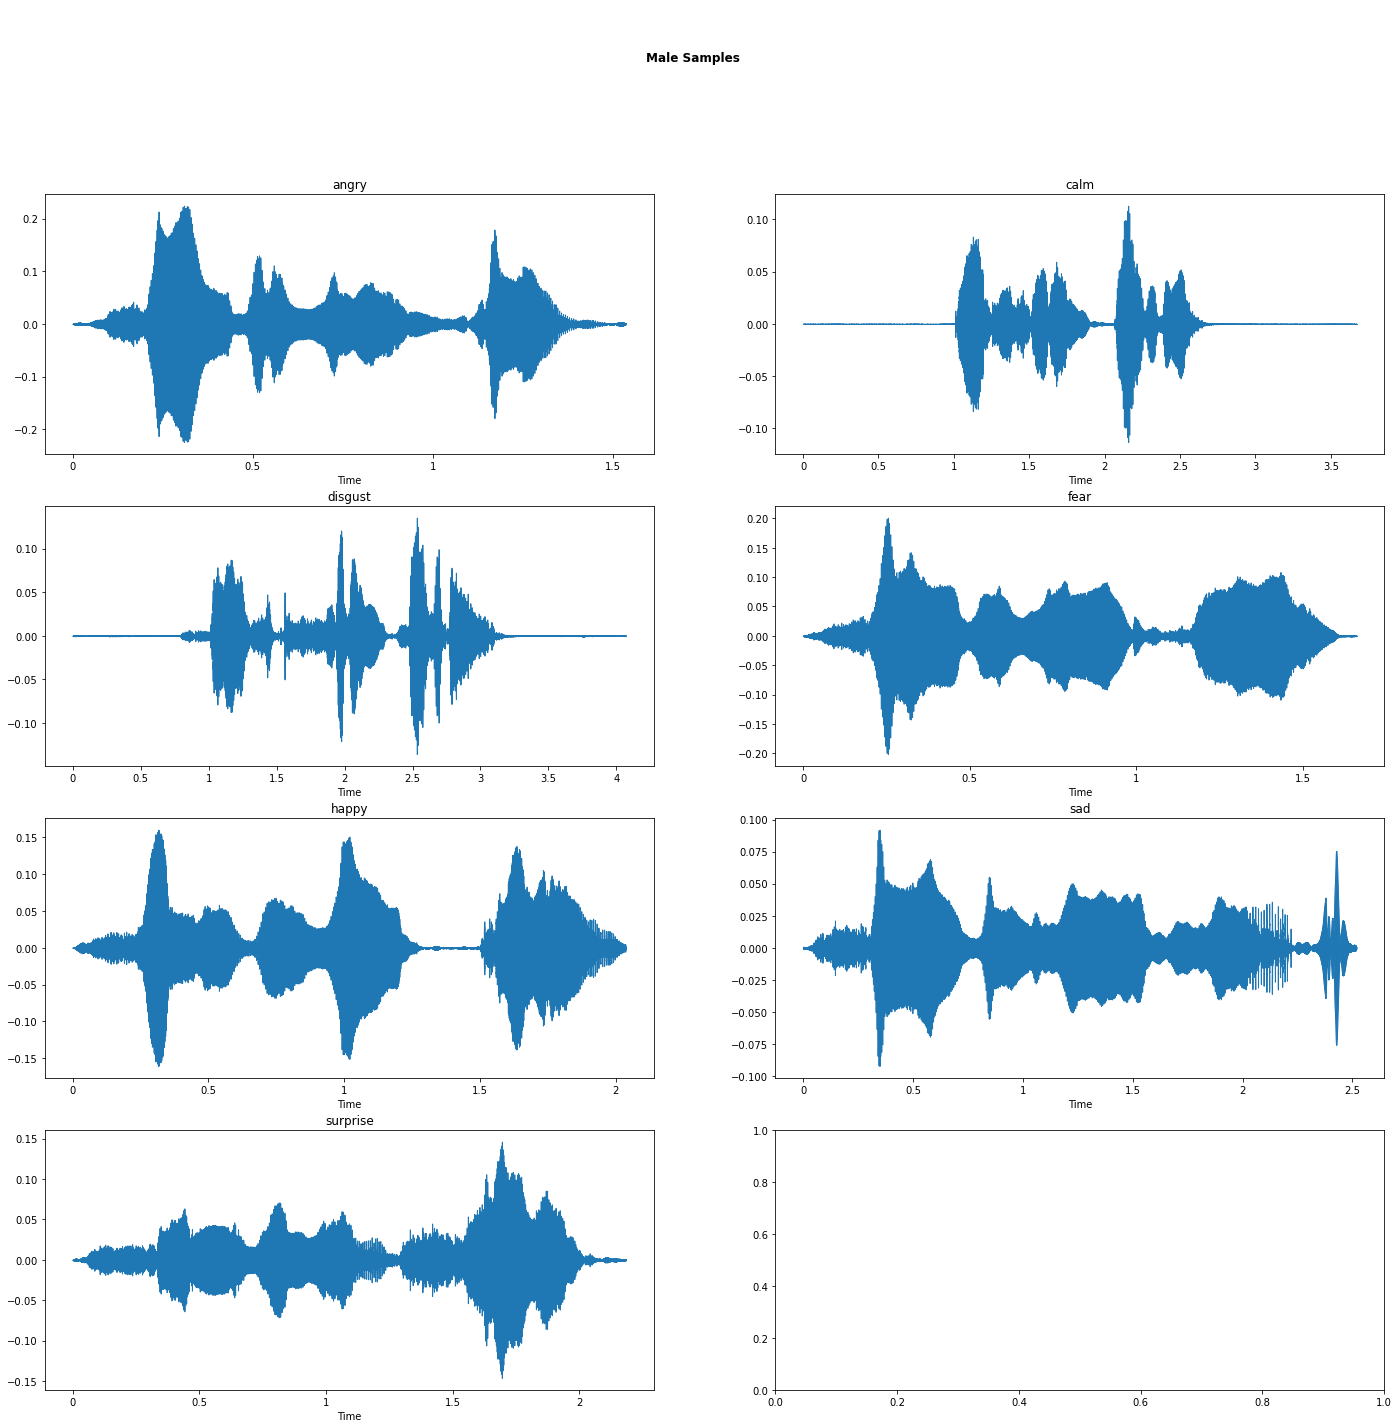

In [18]:
fig, axes = plt.subplots(4, 2, figsize=(24, 22))
plt.suptitle("\n\n\nMale Samples", va='center', fontweight="bold")
for ax, emotion, path in zip(axes.flatten(), EMOTIONS.values(), male_sample):
    signal, sr = librosa.load(path)
    librosa.display.waveshow(signal, sr=sr, ax=ax)
    ax.set(title=emotion)

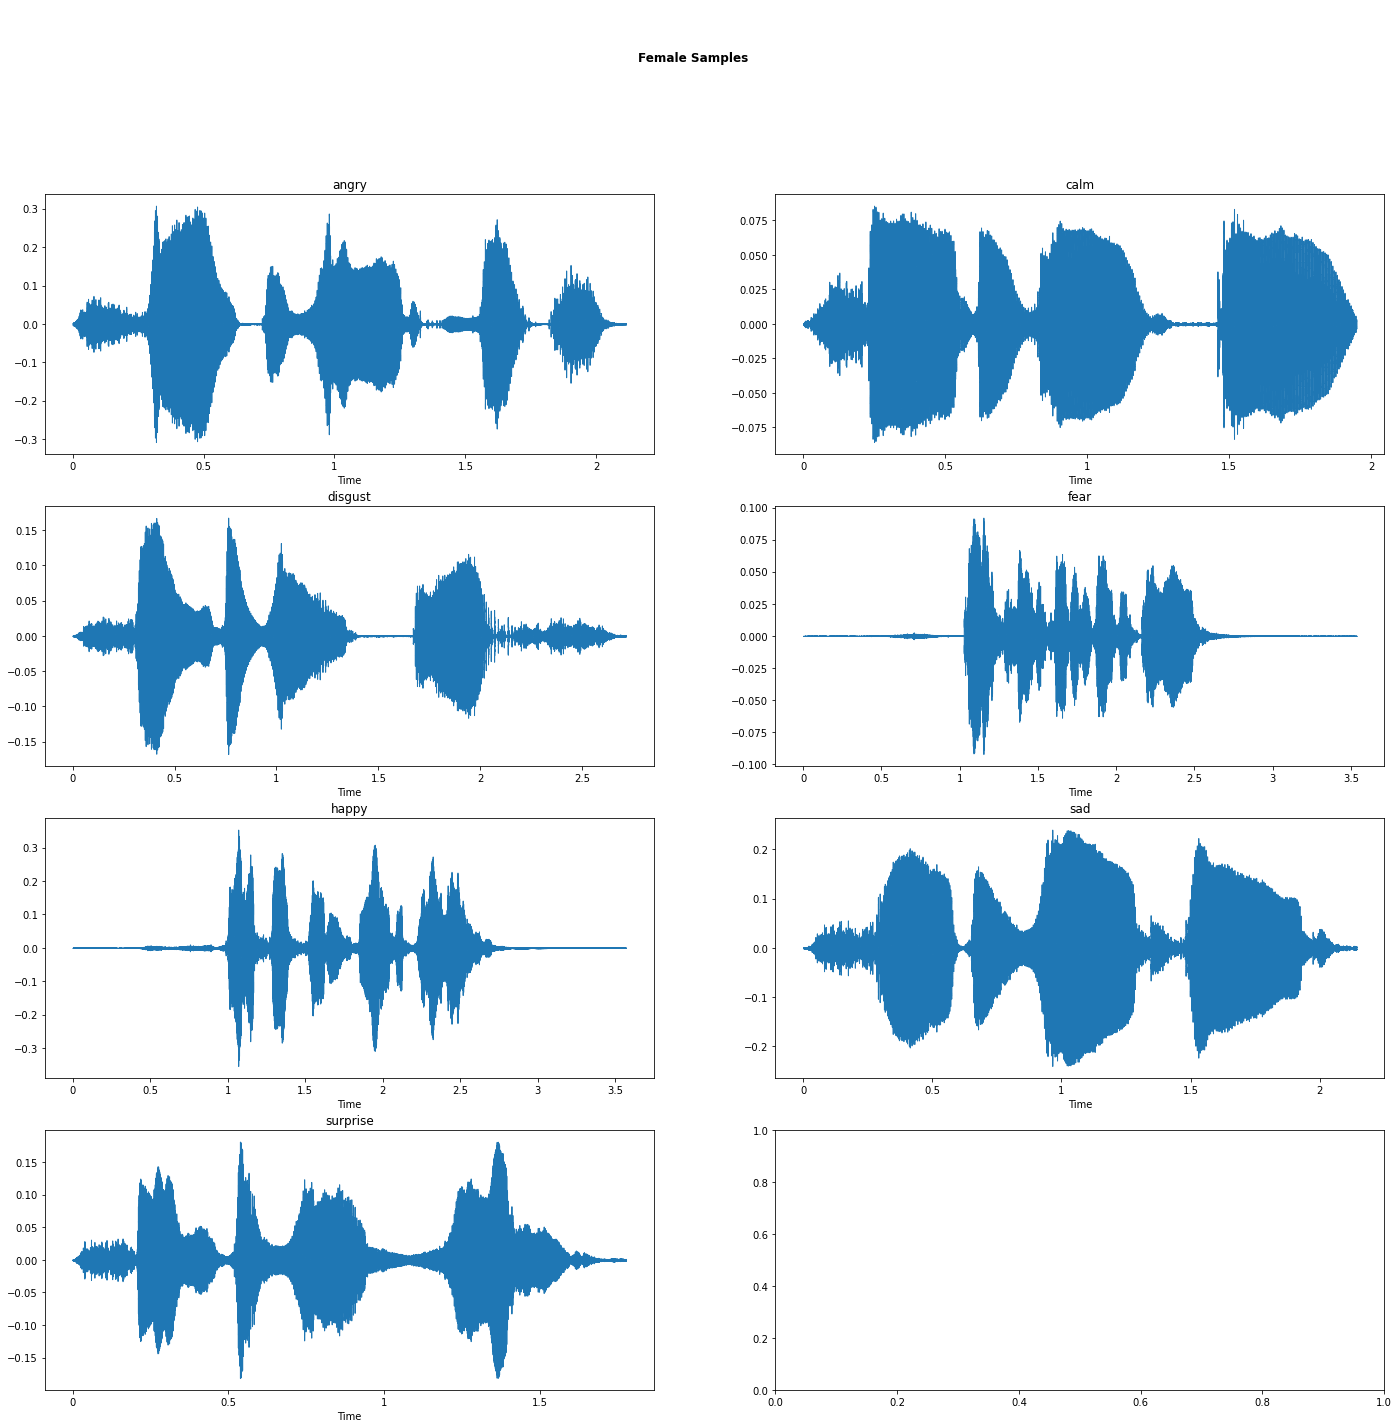

In [19]:
fig, axes = plt.subplots(4, 2, figsize=(24, 22))
plt.suptitle("\n\n\nFemale Samples", va='center', fontweight="bold")
for ax, emotion, path in zip(axes.flatten(), EMOTIONS.values(), female_sample):
    signal, sr = librosa.load(path)
    librosa.display.waveshow(signal, sr=sr, ax=ax)
    ax.set(title=emotion)

# Preprocessing For Single File

In [20]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(16, 6))
    plt.title('{}'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


def create_rmse(data, sr, e):
    rmse = librosa.feature.rms(y=data, frame_length=2048, hop_length=512)
    rmse = rmse[0]
    plt.figure(figsize=(16, 6))
    plt.title('Root Mean Square Energy - {}'.format(e), size=15)
    energy = np.array(
        [sum(abs(data[i:i + 2048]**2)) for i in range(0, len(data), 512)])
    frames = range(len(energy))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=512)
    librosa.display.waveshow(data, sr=sr)
    plt.plot(t, energy / energy.max(), 'r--')  # normalized for visualization
    plt.plot(t[:len(rmse)], rmse / rmse.max(),
             color='g')  # normalized for visualization
    plt.legend(('Energy', 'RMSE'))


def create_melspectrogram(data, sr, e):
    # stft thực hiện biến đổi Fourier.
    X = librosa.feature.melspectrogram(y=data, sr=sr)

    plt.figure(figsize=(16, 6))
    plt.title('MelSpectrogram - {}'.format(e), size=15)
    librosa.display.specshow(X, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()


def create_mfcc(data, sr, e):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
    plt.figure(figsize=(16, 6))
    plt.title('Mel-frequency cepstral coefficient - {}'.format(e), size=15)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()

Sample Rate :  24414


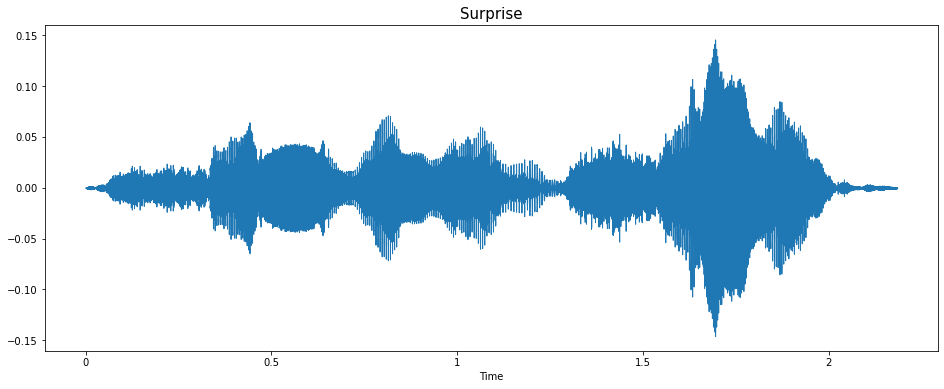

In [21]:
#Taking an audio file form male_sample to perform preprocessing to know the audio data more
path = male_sample[-1]

audio, sr = librosa.load(path, sr=None)
print("Sample Rate : ", sr)
create_waveplot(audio, sr, "Surprise")
ipd.display(ipd.Audio(audio, rate=sr))

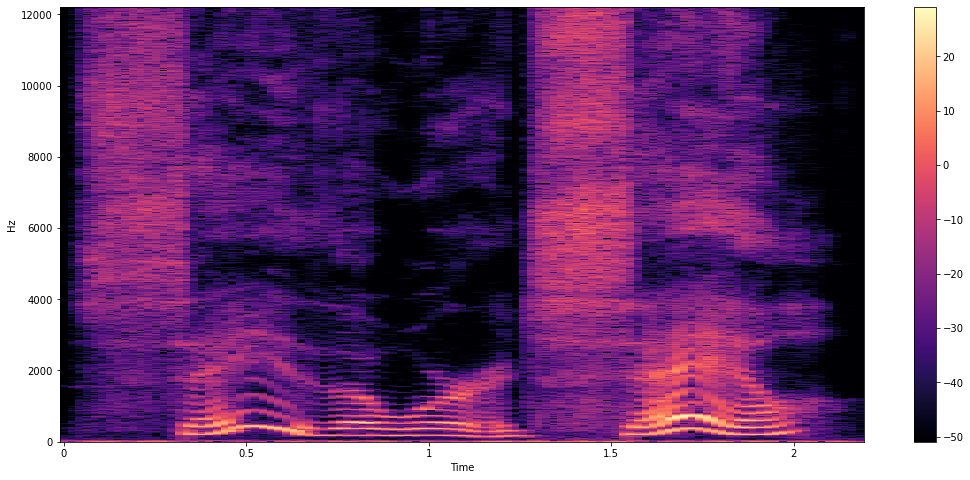

In [22]:
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(18, 8))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

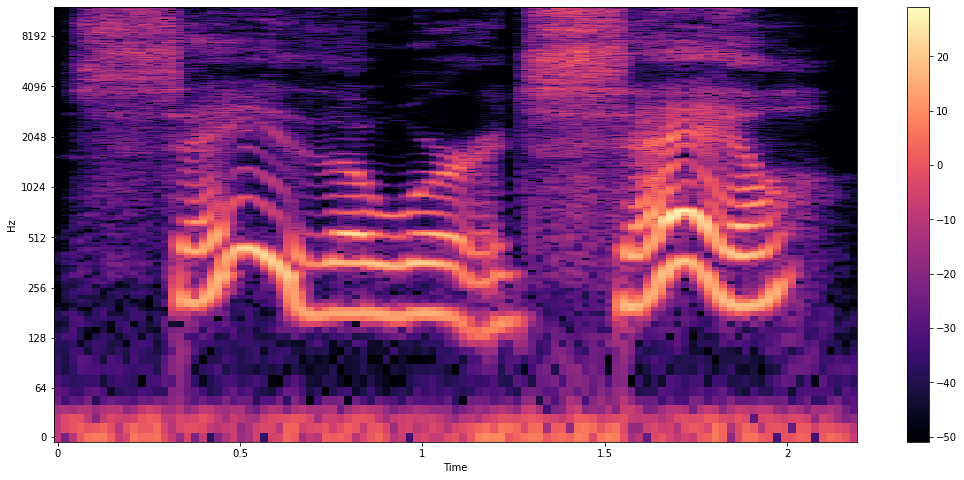

In [23]:
plt.figure(figsize=(18, 8))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

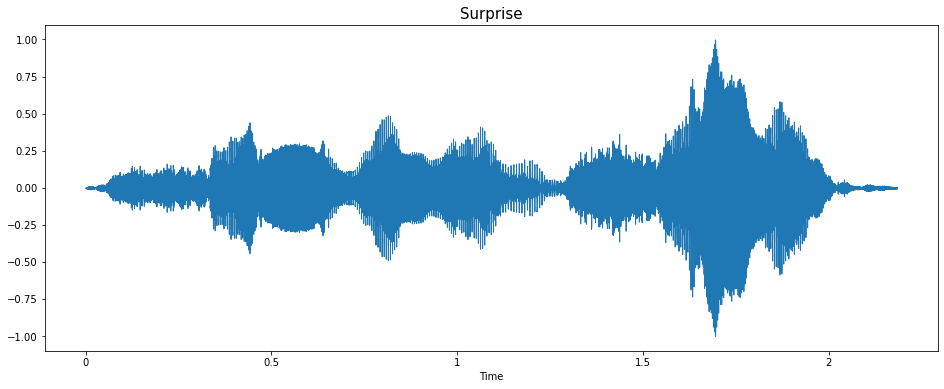

In [24]:
normalizedsound = librosa.util.normalize(audio)
create_waveplot(normalizedsound, sr, "Surprise")
ipd.display(ipd.Audio(normalizedsound, rate=sr))

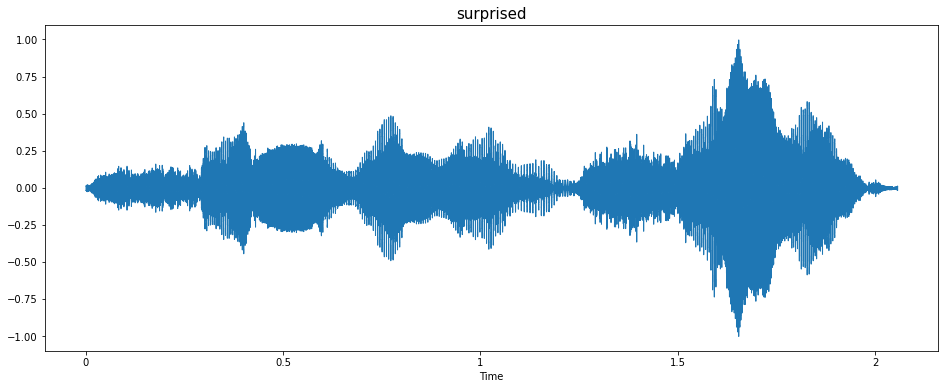

In [25]:
# Trimming the audio to remover silence before and after speech
trimmed_audio, index = librosa.effects.trim(normalizedsound, top_db=30)

create_waveplot(trimmed_audio, sr, "surprised")

ipd.display(ipd.Audio(data=trimmed_audio, rate=sr))

50176


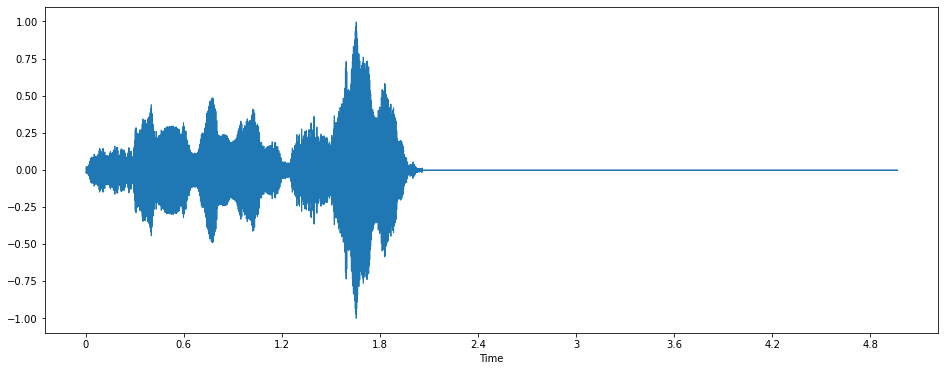

In [26]:
# Padding some values to right side to make all data length equal
# so we have maximum lenght audio file with 173056
print(len(trimmed_audio))
final_audio = np.pad(trimmed_audio, (0, 121212 - len(trimmed_audio)),
                     'constant')

create_waveplot(final_audio, sr, "")

ipd.display(ipd.Audio(data=final_audio, rate=sr))

In [27]:
def noise(data, noise_rate=0.018):
    noise_amp = noise_rate * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data


def stretch(data, rate=0.6):
    return librosa.effects.time_stretch(y=data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, pitch_factor=2):
    return librosa.effects.pitch_shift(y=data,
                                       sr=sampling_rate,
                                       n_steps=pitch_factor)

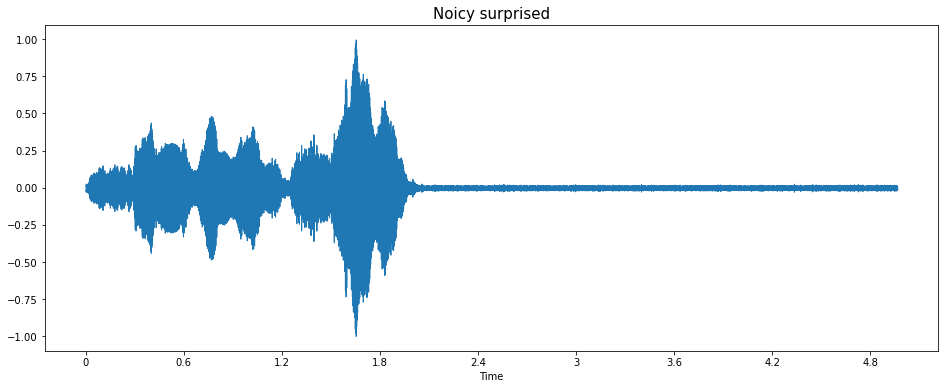

In [28]:
noisy_audio = noise(final_audio)
create_waveplot(noisy_audio, sr, "Noicy surprised")
ipd.display(ipd.Audio(data=noisy_audio, rate=sr))

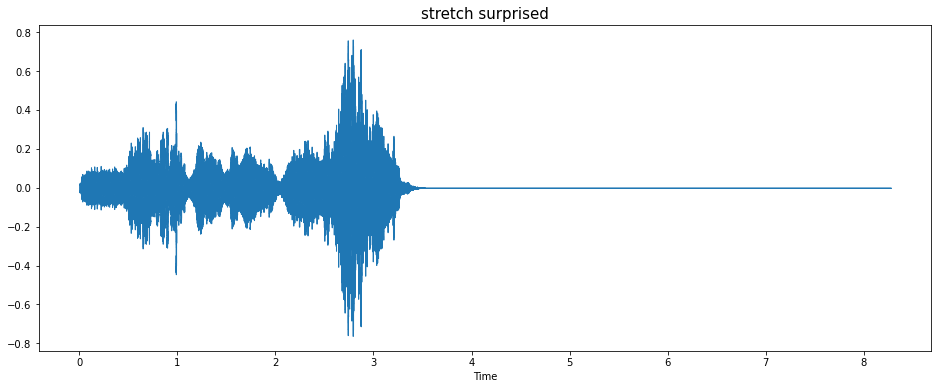

In [29]:
stretch_audio = stretch(final_audio)
create_waveplot(stretch_audio, sr, "stretch surprised")
ipd.display(ipd.Audio(data=stretch_audio, rate=sr))

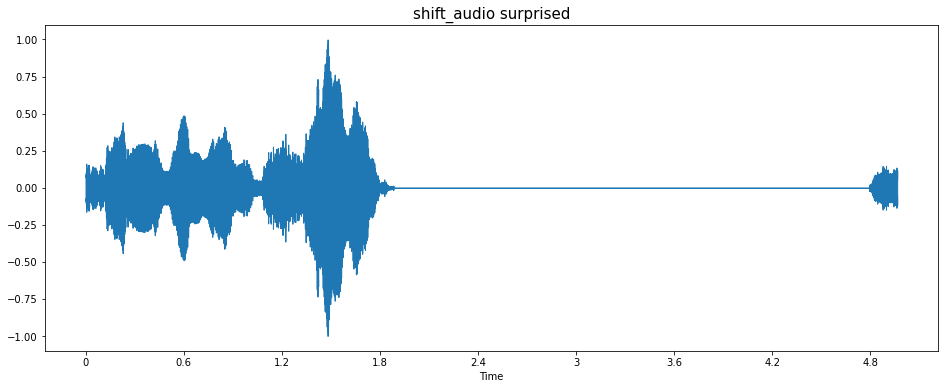

In [30]:
shift_audio = shift(final_audio)
create_waveplot(shift_audio, sr, "shift_audio surprised")
ipd.display(ipd.Audio(data=shift_audio, rate=sr))

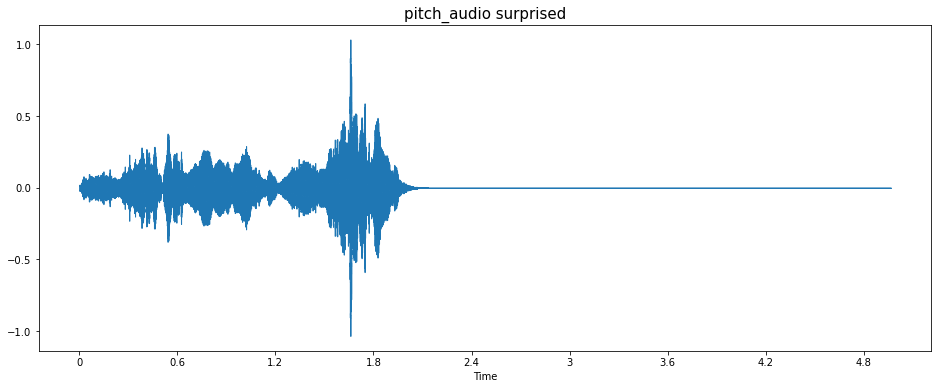

In [31]:
pitch_audio = pitch(final_audio, sr)
create_waveplot(pitch_audio, sr, "pitch_audio surprised")
ipd.display(ipd.Audio(data=pitch_audio, rate=sr))

# Feature Selection For Single File

In [32]:
emos = list(zip(EMOTIONS.values(), emotions_sample))

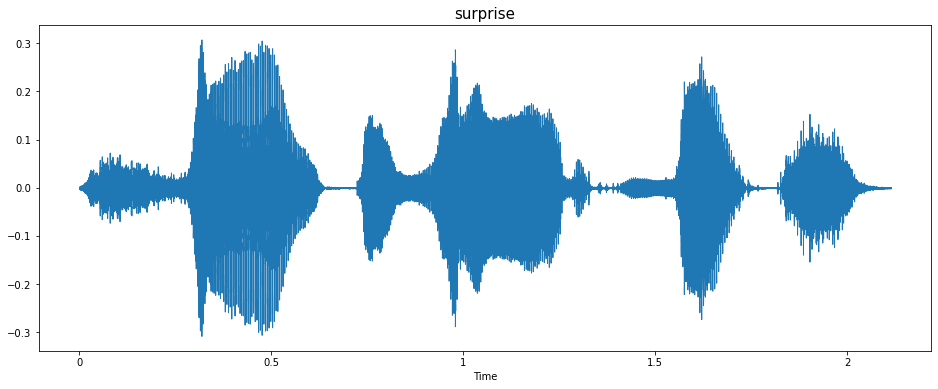

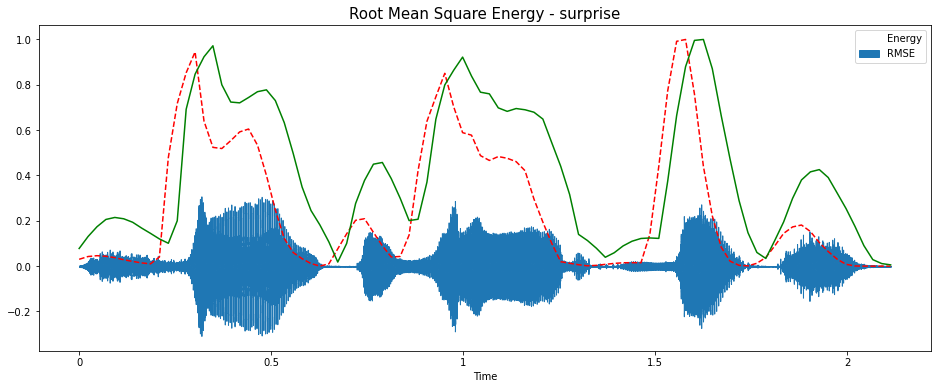

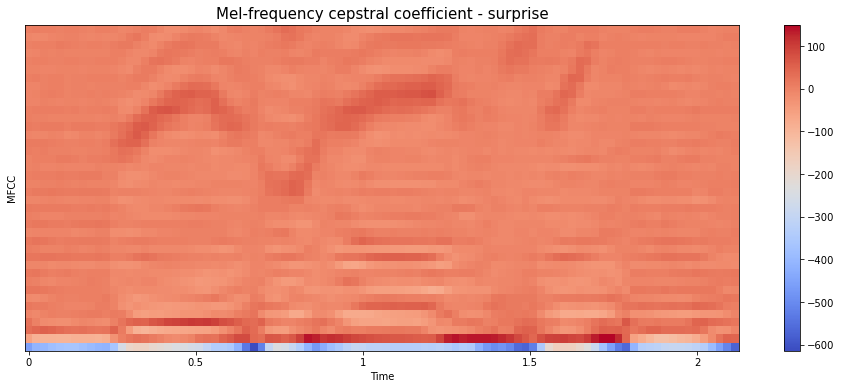

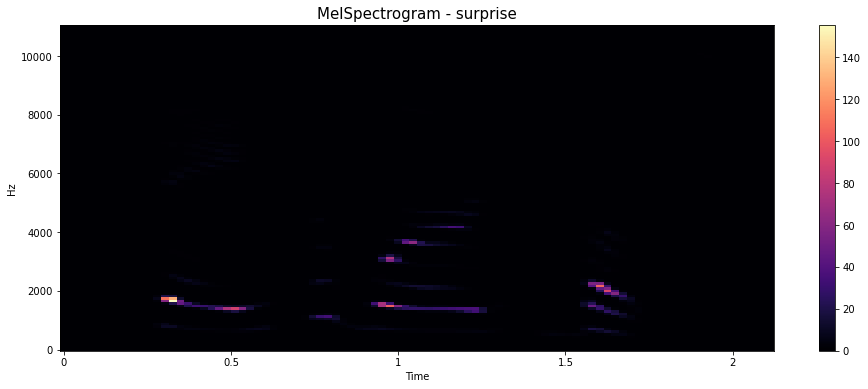

In [33]:
emotions, path = emos[0]
signal, sr = librosa.load(path)
ipd.display(ipd.Audio(data=signal, rate=sr))
create_waveplot(signal, sr, emotion)
create_rmse(signal, sr, emotion)
create_mfcc(signal, sr, emotion)
create_melspectrogram(signal, sr, emotion)

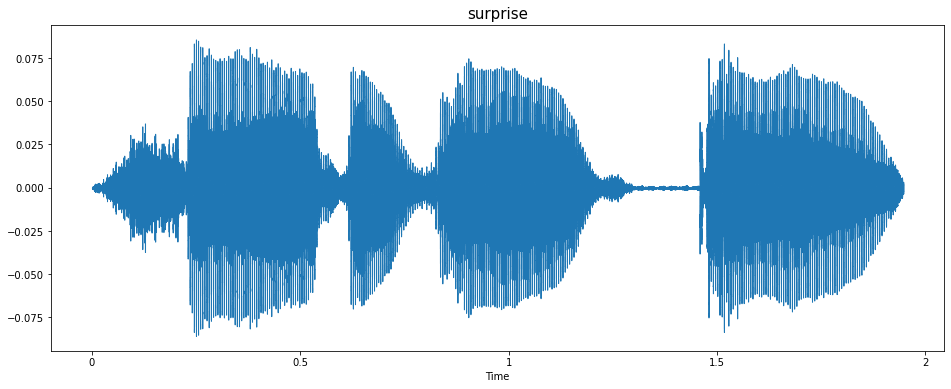

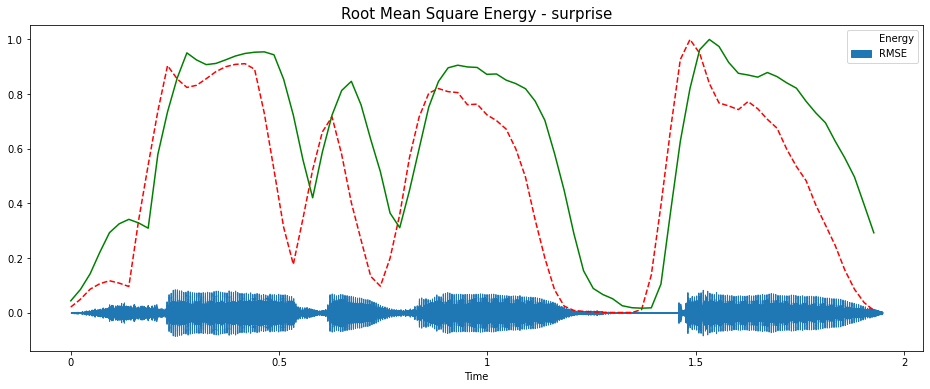

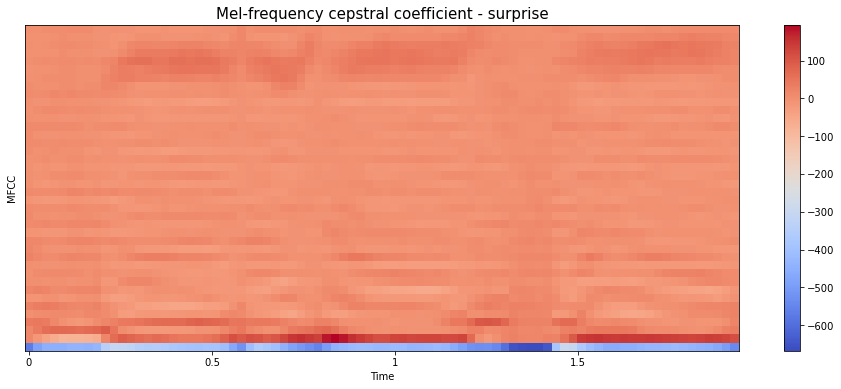

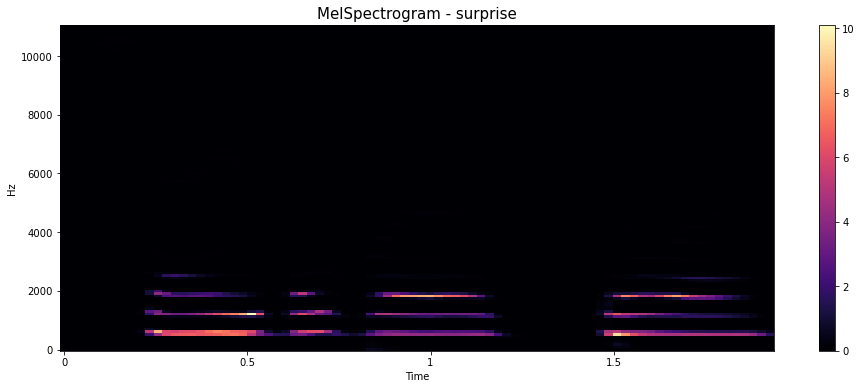

In [34]:
emotions, path = emos[1]
signal, sr = librosa.load(path)
ipd.display(ipd.Audio(data=signal, rate=sr))
create_waveplot(signal, sr, emotion)
create_rmse(signal, sr, emotion)
create_mfcc(signal, sr, emotion)
create_melspectrogram(signal, sr, emotion)

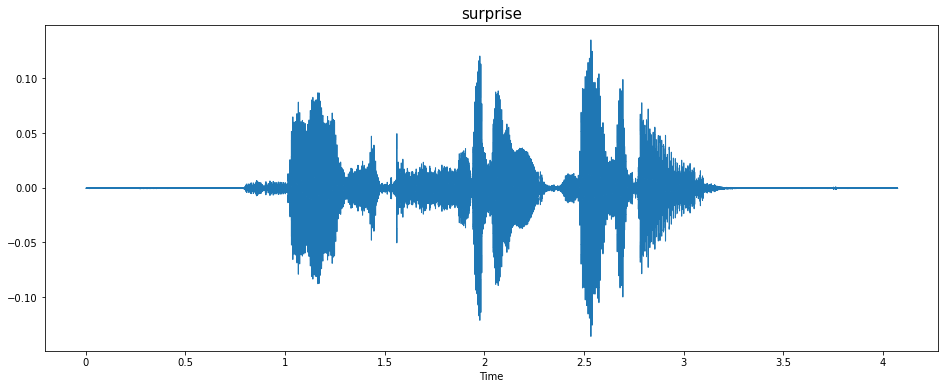

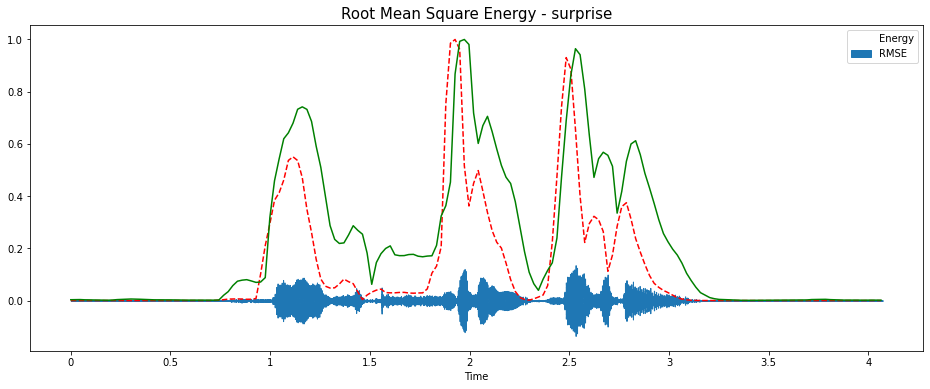

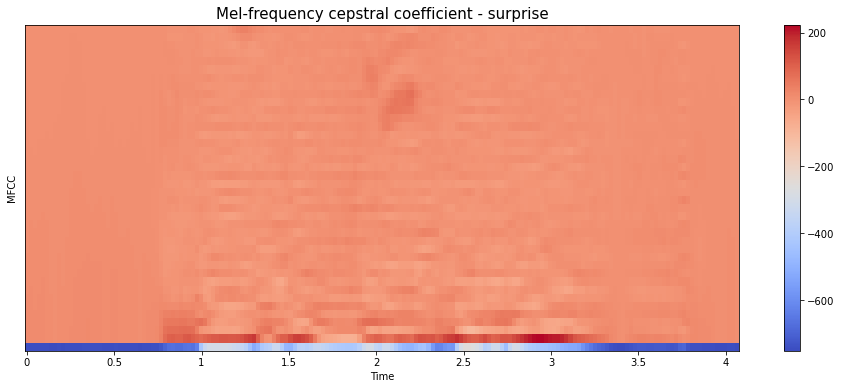

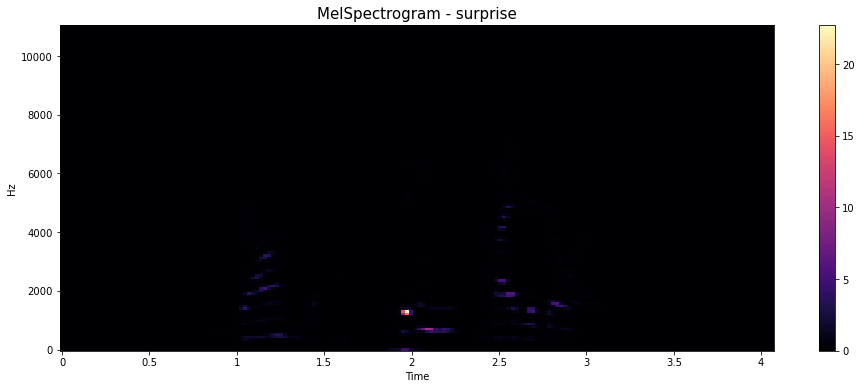

In [35]:
emotions, path = emos[2]
signal, sr = librosa.load(path)
ipd.display(ipd.Audio(data=signal, rate=sr))
create_waveplot(signal, sr, emotion)
create_rmse(signal, sr, emotion)
create_mfcc(signal, sr, emotion)
create_melspectrogram(signal, sr, emotion)

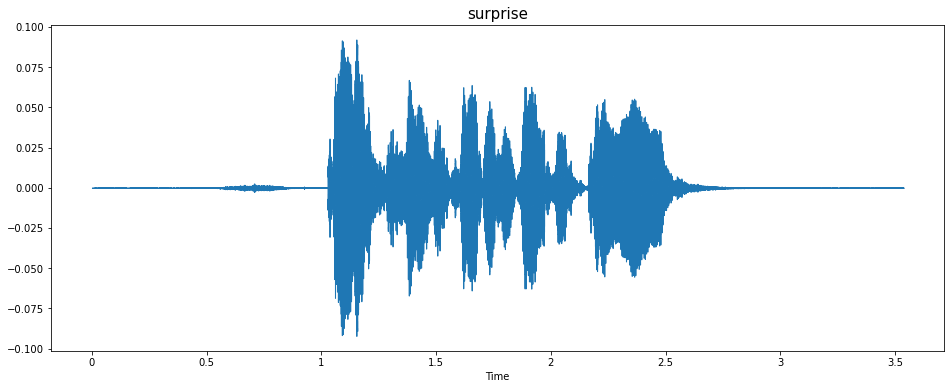

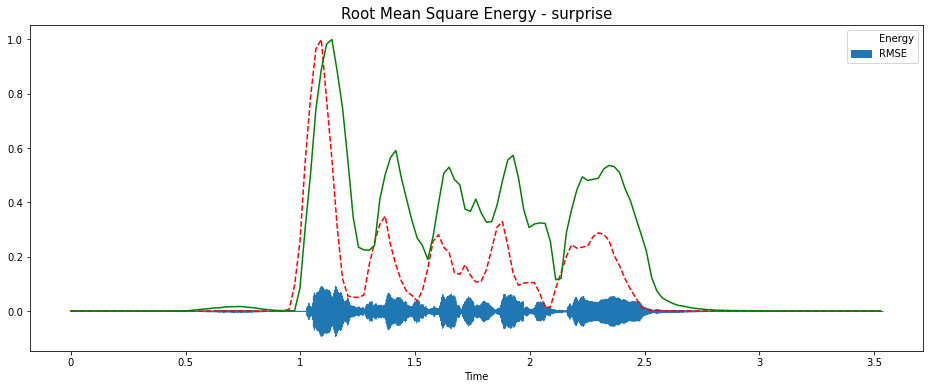

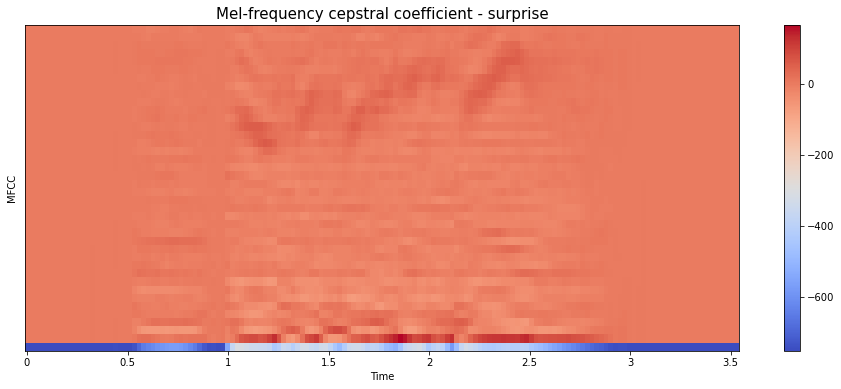

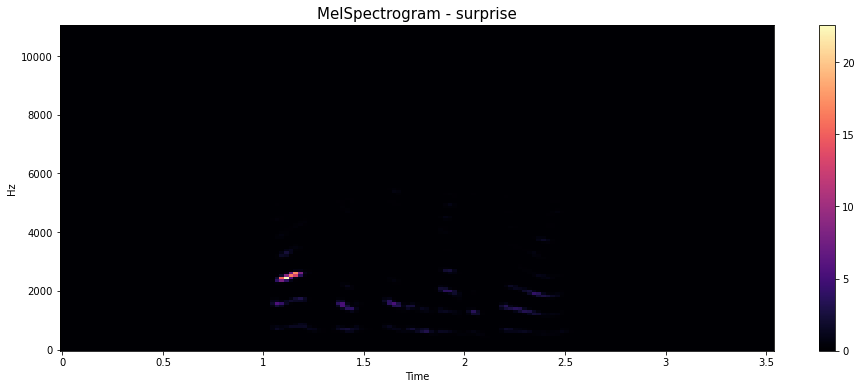

In [36]:
emotions, path = emos[3]
signal, sr = librosa.load(path)
ipd.display(ipd.Audio(data=signal, rate=sr))
create_waveplot(signal, sr, emotion)
create_rmse(signal, sr, emotion)
create_mfcc(signal, sr, emotion)
create_melspectrogram(signal, sr, emotion)

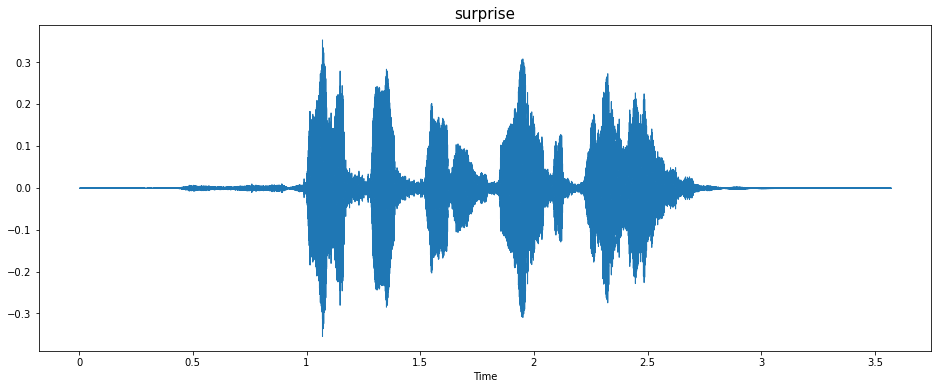

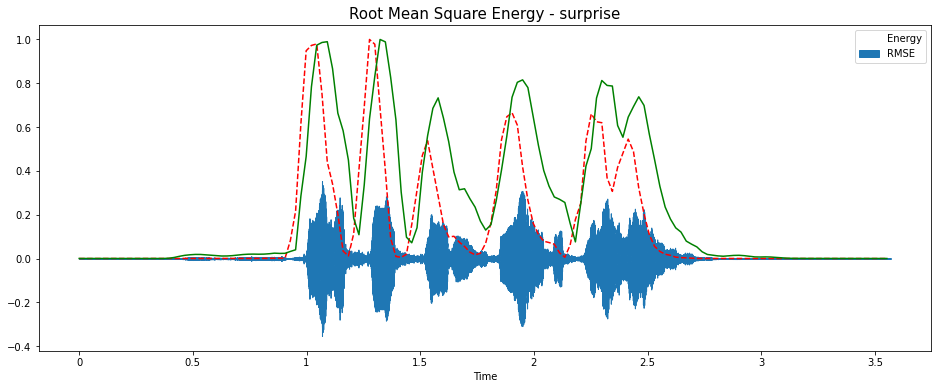

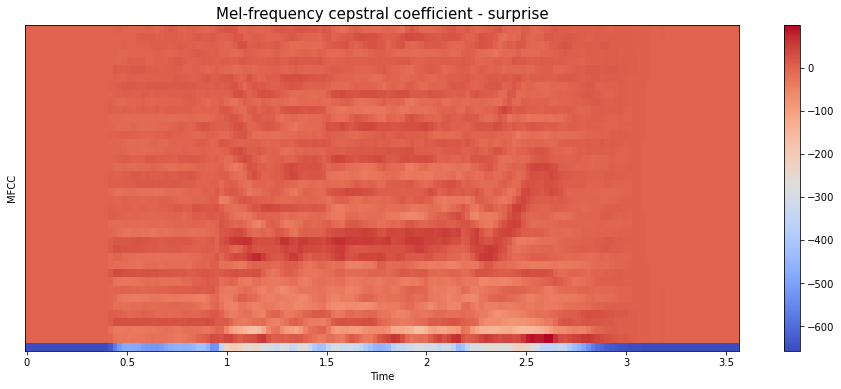

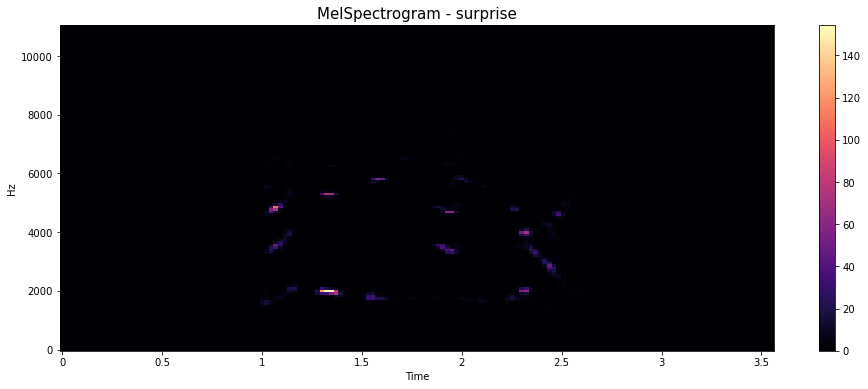

In [37]:
emotions, path = emos[4]
signal, sr = librosa.load(path)
ipd.display(ipd.Audio(data=signal, rate=sr))
create_waveplot(signal, sr, emotion)
create_rmse(signal, sr, emotion)
create_mfcc(signal, sr, emotion)
create_melspectrogram(signal, sr, emotion)

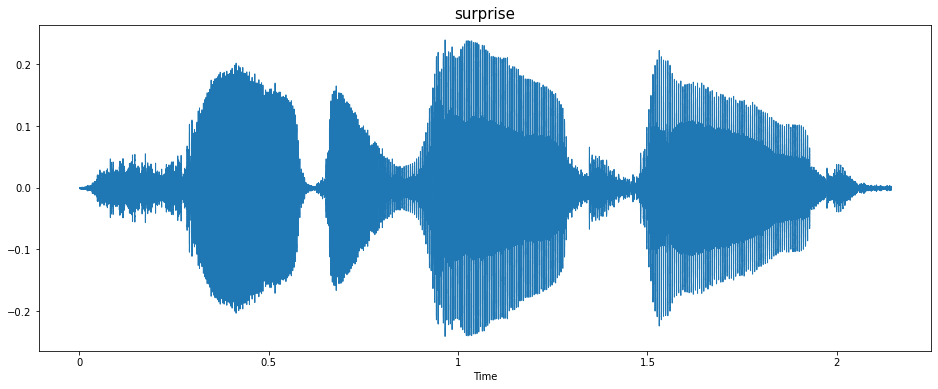

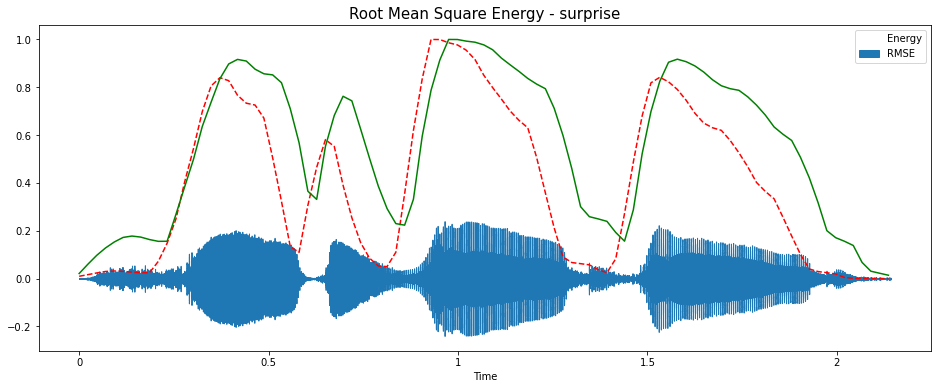

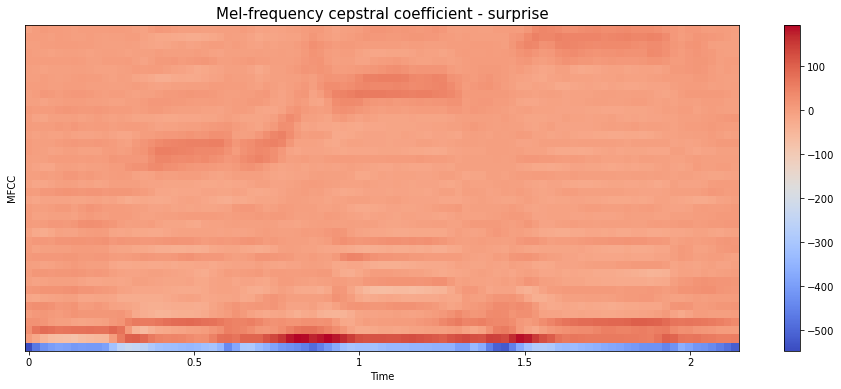

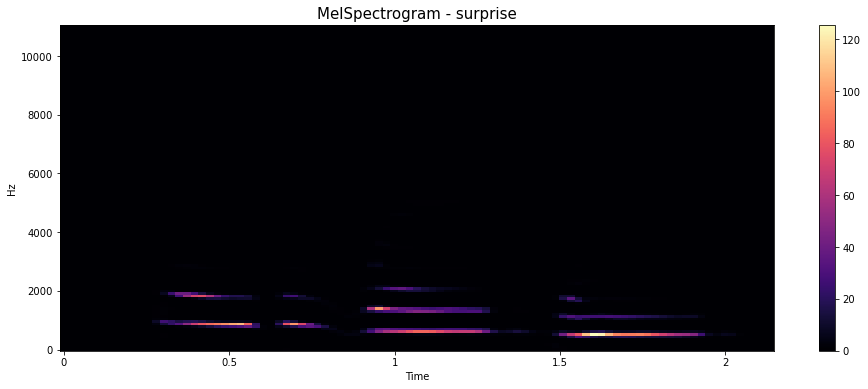

In [38]:
emotions, path = emos[5]
signal, sr = librosa.load(path,)
ipd.display(ipd.Audio(data=signal, rate=sr))
create_waveplot(signal, sr, emotion)
create_rmse(signal, sr, emotion)
create_mfcc(signal, sr, emotion)
create_melspectrogram(signal, sr, emotion)

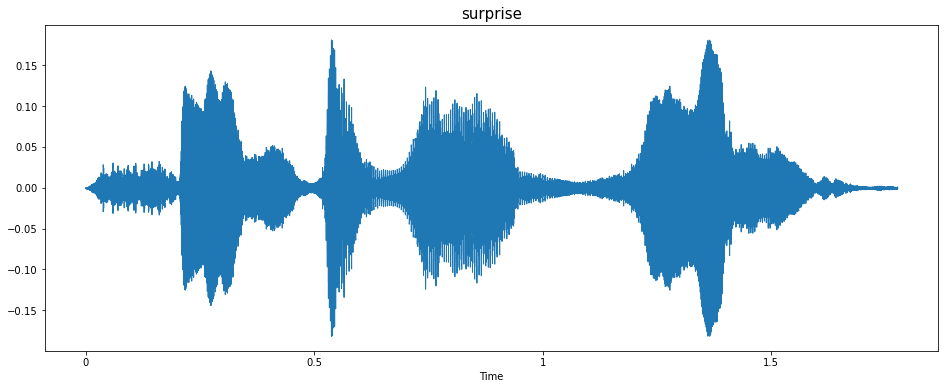

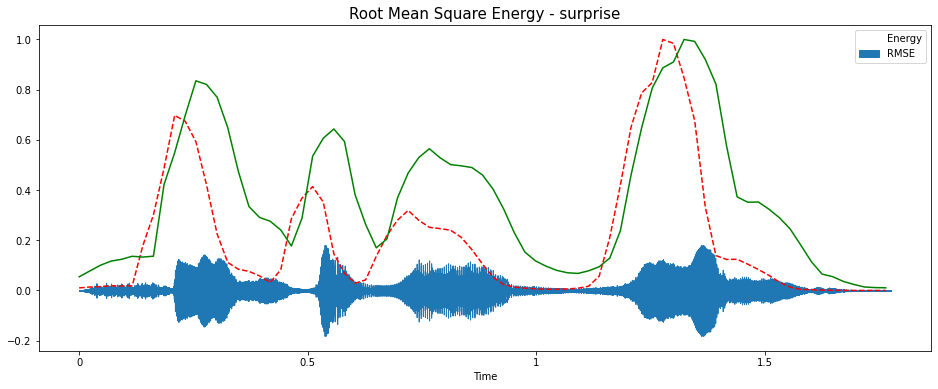

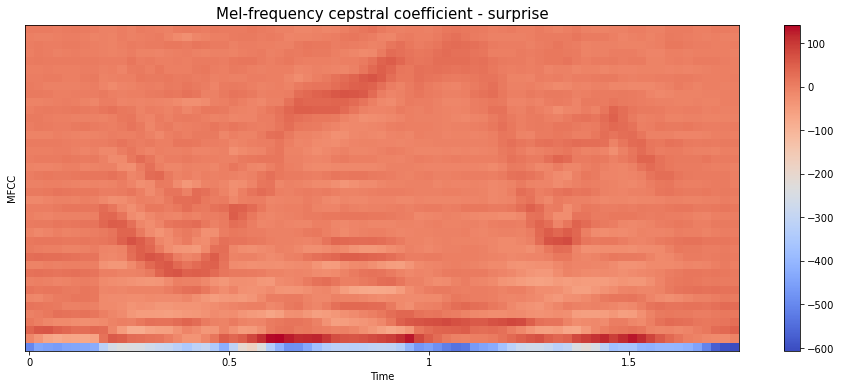

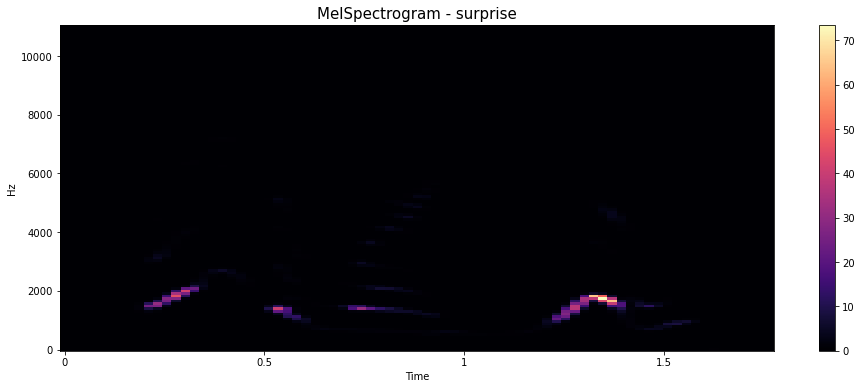

In [39]:
emotions, path = emos[6]
signal, sr = librosa.load(path,)
ipd.display(ipd.Audio(data=signal, rate=sr))
create_waveplot(signal, sr, emotion)
create_rmse(signal, sr, emotion)
create_mfcc(signal, sr, emotion)
create_melspectrogram(signal, sr, emotion)

In [40]:
def extract_features(audio, sr, frame_length=2048, hop_length=512):
    f1 = librosa.feature.rms(
        y=final_audio, frame_length=frame_length,
        hop_length=hop_length).T  # Energy - Root Mean Square

    f2 = librosa.feature.melspectrogram(y=final_audio,
                                        sr=sr,
                                        n_fft=frame_length,
                                        hop_length=hop_length).T

    f3 = librosa.feature.mfcc(y=final_audio,
                              sr=sr,
                              n_mfcc=40,
                              hop_length=hop_length).T  # MFCC

    # Filling the data lists
    return f1, f2, f3

In [59]:
# import time

tic = time.perf_counter()
scaler = StandardScaler()

# Initialize data lists
rms = []
mfcc = []
mel = []
emotions = []
max_length = 121212  # 2.6 Seconds
frame_length = 2048
hop_length = 512

for path, emotion in dataset[['path', 'label']].to_numpy():

    # Fetch the sample rate.
    rawsound, sr = librosa.load(path=path)
    # Load the audio file.
    normalizedsound = librosa.util.normalize(rawsound)
    # Transform the normalized audio to np.array of samples.

    # Trim silence from the beginning and the end.
    trimmed_audio, index = librosa.effects.trim(y=normalizedsound, top_db=30)

    # Pad for duration equalization.
    if len(trimmed_audio) > max_length:
        trimmed_audio = trimmed_audio[0:max_length]
    final_audio = np.pad(trimmed_audio, (0, max_length - len(trimmed_audio)),
                         'constant')

    f1, f2, f3 = extract_features(final_audio, sr)
    rms.append(scaler.fit_transform(f1))
    mel.append(scaler.fit_transform(f2))
    mfcc.append(scaler.fit_transform(f3))
    emotions.append(emotion)

    # noise_audio = noise(trimmed_audio)
    # if len(noise_audio) > max_length:
    #     noise_audio = noise_audio[0:max_length]
    # noise_audio = np.pad(noise_audio, (0, max_length - len(noise_audio)),
    #                      'constant')
    # n_f1, n_f2, n_f3 = extract_features(noise_audio, sr)
    # rms.append(scaler.fit_transform(n_f1))
    # mel.append(scaler.fit_transform(n_f2))
    # mfcc.append(scaler.fit_transform(n_f3))
    # emotions.append(emotion)

f_rms = np.asarray(rms)
f_mfccs = np.asarray(mfcc)
f_mel = np.asarray(mel)

# Concatenating all features to 'X' variable.
X = np.concatenate((f_rms, f_mel, f_mfccs), axis=2)
# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions)
Y = np.expand_dims(Y, axis=1)
enc = OneHotEncoder()
Y = enc.fit_transform(Y)
Y = Y.toarray()
toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 4.4794 minutes


In [15]:
enc.categories_[0]

array(['female_angry', 'female_calm', 'female_disgust', 'female_fear',
       'female_happy', 'female_sad', 'female_surprise', 'male_angry',
       'male_calm', 'male_disgust', 'male_fear', 'male_happy', 'male_sad',
       'male_surprise'], dtype=object)

In [60]:
print('RMS shape:', f_rms.shape)
print('MFCCs shape:', f_mfccs.shape)
print('mel shape:', f_mel.shape)

print('X shape:', X.shape)
print('Y shape:', Y.shape)

RMS shape: (4240, 237, 1)
MFCCs shape: (4240, 237, 40)
mel shape: (4240, 237, 128)
X shape: (4240, 237, 169)
Y shape: (4240, 14)


In [61]:
np.min(X), np.max(X)

(-7.934384, 14.859157)

In [62]:
# # Saving Numpy arrays as Features and Labels
np.save('G_Features.npy', X)
np.save('G_Labels.npy', Y)

In [2]:
X = np.load('Data/G_Features.npy')
Y = np.load('Data/G_Labels.npy')

# Model Training

In [3]:
from keras.models import Sequential
import tensorflow as tf
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers import Dropout
from keras.layers import LSTM, Dense

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42,
)

In [47]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(520, return_sequences=True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(347, return_sequences=True))
model.add(layers.LSTM(213, return_sequences=True))
model.add(layers.LSTM(192))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(14, activation='softmax'))
print(model.summary())

batch_size = 256

# Callbacks functions
checkpoint_path = 'Models/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path,
                                     save_best_only=True,
                                     monitor='val_categorical_accuracy',
                                     mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                    factor=0.005,
                                    patience=100)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-31 03:34:04.477060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-31 03:34:04.477389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 237, 520)          1435200   
                                                                 
 lstm_1 (LSTM)               (None, 237, 347)          1204784   
                                                                 
 lstm_2 (LSTM)               (None, 237, 213)          477972    
                                                                 
 lstm_3 (LSTM)               (None, 192)               311808    
                                                                 
 dense (Dense)               (None, 64)                12352     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 14)                4

In [48]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['categorical_accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[mcp_save, rlrop, tensorboard_callback],
                    use_multiprocessing=True)
# Define the best weights to the model.
# model.load_weights(checkpoint_path)

Epoch 1/200


2022-07-31 03:34:07.486559: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-31 03:34:09.054727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 03:34:09.705257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 03:34:10.842772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 03:34:11.192298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 03:34:11.630902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 03:34:13.018260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

27/27 [==============================] - ETA: 0s - loss: 2.4991 - categorical_accuracy: 0.1493

2022-07-31 03:35:05.037790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 03:35:05.198342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 03:35:06.164444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 03:35:07.161760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 03:35:07.734364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 66s 2s/step - loss: 2.4991 - categorical_accuracy: 0.1493 - val_loss: 2.2728 - val_categorical_accuracy: 0.2606 - lr: 0.0010
Epoch 2/200
27/27 [==============================] - 53s 2s/step - loss: 2.0105 - categorical_accuracy: 0.2786 - val_loss: 1.7903 - val_categorical_accuracy: 0.3638 - lr: 0.0010
Epoch 3/200
27/27 [==============================] - 52s 2s/step - loss: 1.5418 - categorical_accuracy: 0.4472 - val_loss: 1.5828 - val_categorical_accuracy: 0.3909 - lr: 0.0010
Epoch 4/200
27/27 [==============================] - 51s 2s/step - loss: 1.4798 - categorical_accuracy: 0.4515 - val_loss: 1.5003 - val_categorical_accuracy: 0.4387 - lr: 0.0010
Epoch 5/200
27/27 [==============================] - 50s 2s/step - loss: 1.1956 - categorical_accuracy: 0.5663 - val_loss: 1.2318 - val_categorical_accuracy: 0.5177 - lr: 0.0010
Epoch 6/200
27/27 [==============================] - 47s 2s/step - loss: 1.0916 - categorical_accuracy: 0.5877 - val_loss:

KeyboardInterrupt: 

In [5]:
model = load_model('Models/G_SER.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['categorical_accuracy'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-31 10:40:26.958108: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-31 10:40:26.958512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


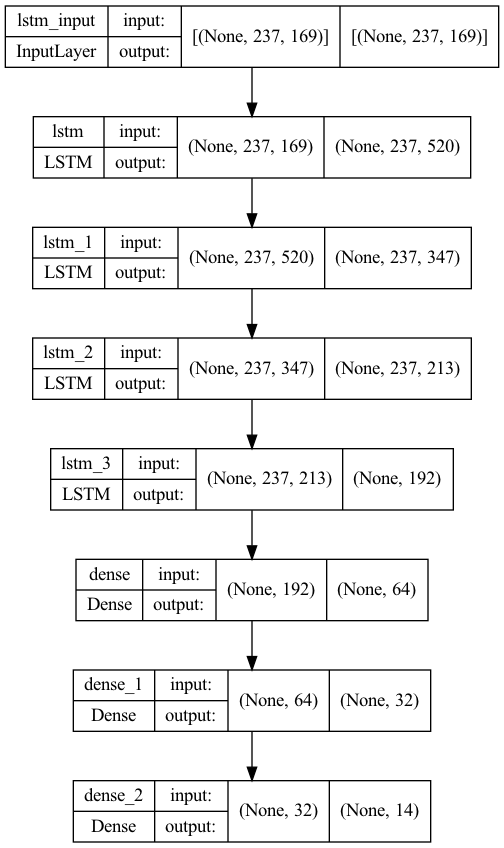

In [6]:
tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True)

In [9]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)

53/53 - 6s - loss: 0.1903 - categorical_accuracy: 0.9564 - 6s/epoch - 104ms/step


In [10]:
plt.style.use('default')
plt.rc('figure', titlesize=20)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

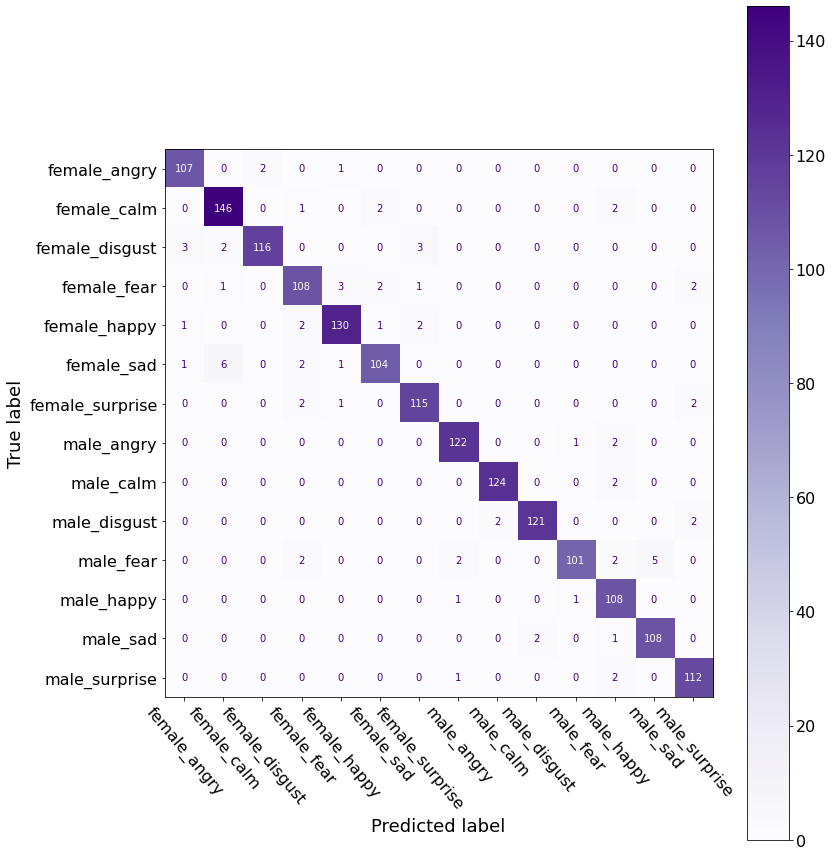

In [21]:
y_pred = model.predict(X_test)
cm = confusion_matrix(enc.inverse_transform(y_test),
                      enc.inverse_transform(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=enc.categories_[0])
fig, ax = plt.subplots(
    figsize=(12, 12),
    tight_layout=True,
)

disp.plot(cmap=plt.cm.Purples, ax=ax, xticks_rotation=310)
plt.savefig("G_Confusion_Matrix_Validation_Data.png", dpi=fig.dpi)

plt.show()

In [17]:
X_real = np.load('Data/G_Base_Data_Features.npy')
y_real = np.load('Data/G_Base_Data_Labels.npy')

In [18]:
loss, acc = model.evaluate(X_real, y_real, verbose=2)

2022-07-31 10:44:42.251590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 10:44:42.397701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 10:44:42.796430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 10:44:43.150073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-31 10:44:43.499871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


133/133 - 17s - loss: 0.0832 - categorical_accuracy: 0.9759 - 17s/epoch - 129ms/step


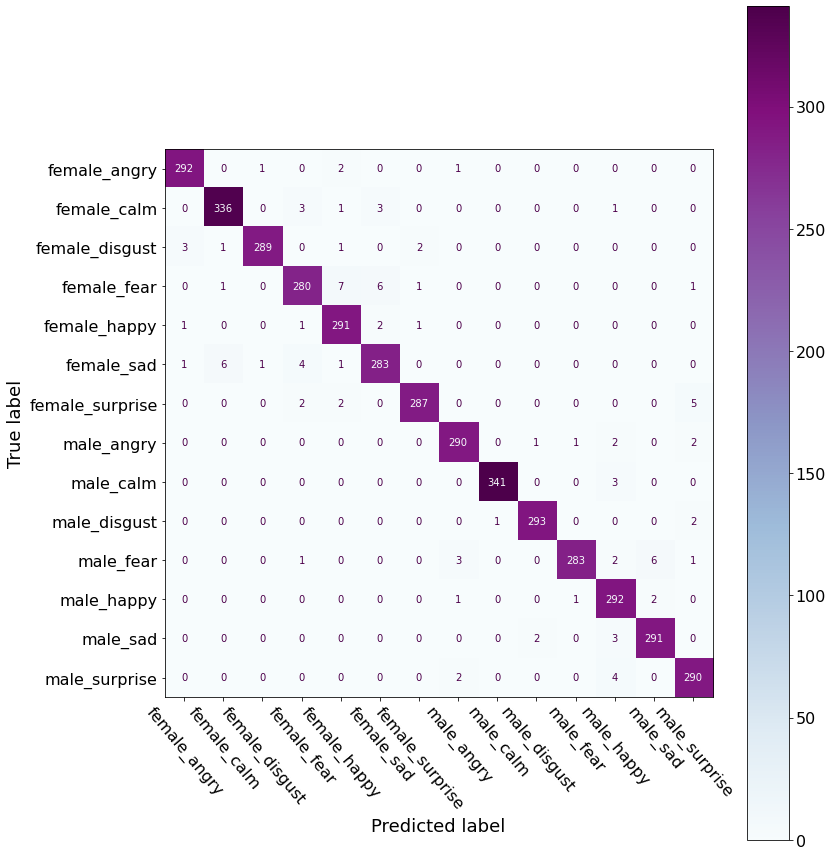

In [22]:
y_pred = model.predict(X_real)
cm = confusion_matrix(enc.inverse_transform(y_real),
                      enc.inverse_transform(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=enc.categories_[0])
fig, ax = plt.subplots(
    figsize=(12, 12),
    tight_layout=True,
)

disp.plot(cmap=plt.cm.BuPu, ax=ax, xticks_rotation=310)
plt.savefig("G_Confusion_Matrix_Base_Data.png", dpi=fig.dpi)

plt.show()